In [1]:
# Copyright (c) 2022, Gonzalo Ferrer, Dmitrii Iarosh, Anastasiia Kornilova
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [7]:
import mrob
import numpy as np
import os
import pandas as pd
import open3d as o3d
import pickle

from matplotlib import pyplot as plt
from tqdm import tqdm

In [8]:
from plane_backends.solver_factory import create_solver_by_name

from metrics.ape import ape
from metrics.rpe import rpe

from perturbation.perturbation import Perturbation, generate_random_pose_shift

In [9]:
def save_generated_data(generated_data, perturbed_poses, folder_name):
    os.mkdir(folder_name)
    for i, _ in enumerate(perturbed_poses):
        points = np.vstack(generated_data.get_point_cloud(i))
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(points)
        o3d.io.write_point_cloud(os.path.join(folder_name, f'{i}.pcd'), pcd)

    gt_poses = [T.T() for T in generated_data.get_trajectory()]
    with open(os.path.join(folder_name, 'gt_poses.pkl'), 'wb') as f:
        pickle.dump(gt_poses, f)

    with open(os.path.join(folder_name, 'pert_poses.pkl'), 'wb') as f:
        pickle.dump(perturbed_poses, f)

In [10]:
def generated_data_to_observations(generated_data, poses_count):
    observations = []
    for i in range(poses_count):
        observation = {}
        points = np.vstack(generated_data.get_point_cloud(i))
        labels = generated_data.get_point_plane_ids(i)
        for label in np.unique(labels):
            point_indices = np.where(labels == label)[0]
            observation[label] = points[point_indices]

        observations.append(observation)
    return observations

In [23]:
planes_count_list = [5] # [5, 10, 25, 50, 100]
poses_count_list = [5, 10, 25, 50, 75]
point_noise_list = [0.005] # [0.005, 0.01, 0.02, 0.04, 0.08]
points_count_list = [5] # [5, 10, 25, 50, 100, 200]
perturbations = [
    Perturbation(rotation_shift=1, translation_shift=0.01),
    Perturbation(rotation_shift=5, translation_shift=0.05),
    Perturbation(rotation_shift=10, translation_shift=0.1),
    Perturbation(rotation_shift=15, translation_shift=0.15),
    Perturbation(rotation_shift=20, translation_shift=0.2),
]
bias_noise = 0.01
T0 = mrob.geometry.SE3(np.eye(4))
solvers = [
    'bareg',
    'pi-factor',
    'ef-centered',
]
df_stat = pd.DataFrame()

SAMPLES_COUNT = 100

ind = 0
for perturbation in perturbations:
    for points_count in points_count_list:
        for point_noise in point_noise_list:
            for planes_count in tqdm(planes_count_list):
                for poses_count in poses_count_list:
                    for sample_index in range(SAMPLES_COUNT):
                        # Generate synthetic data
                        total_points_count = planes_count * points_count
                        generated_data = mrob.registration.CreatePoints(
                            total_points_count,
                            planes_count,
                            poses_count,
                            point_noise,
                            bias_noise,
                            T0
                        )
                        name = '_'.join(
                            [
                                str(points_count),
                                str(planes_count),
                                str(poses_count),
                                str(point_noise),
                                str(sample_index),
                                str(perturbation.rotation_shift),
                                str(perturbation.translation_shift)
                            ]
                        )
                        observations = generated_data_to_observations(generated_data, poses_count)
                        gt_poses = [T.T() for T in generated_data.get_trajectory()]

                        # Apply perturbations
                        perturbed_poses = []
                        for i, gt_pose in enumerate(gt_poses):
                            perturbed_poses.append(
                                gt_pose @ generate_random_pose_shift(
                                    perturbation.rotation_shift / 180 * np.pi,
                                    perturbation.translation_shift
                                )
                            )

                        # save_generated_data(generated_data, perturbed_poses, name)

                        # Estimate trajectory with each backend
                        initial_trajectory = perturbed_poses
                        for solver_name in solvers:
                            solver = create_solver_by_name(solver_name, iterations_count=300)
                            refined_poses, iterations_used_count, optimization_time = solver.solve(
                                observations,
                                initial_trajectory
                            )
                            ape_translation, ape_rotation = ape(gt_poses[:poses_count], refined_poses[:poses_count])
                            rpe_translation, rpe_rotation = rpe(gt_poses[:poses_count], refined_poses[:poses_count])
                            stat = {
                                'sample': sample_index,
                                'pose_perturbation': '{}'.format(str(perturbation)),
                                'point_noise': point_noise,
                                'planes_count': planes_count,
                                'poses_count': poses_count,
                                'points_count': points_count,
                                'time': optimization_time,
                                'solver': solver_name,
                                'iterations': iterations_used_count,
                                'ape_rotation': ape_rotation,
                                'rpe_rotation': rpe_rotation,
                                'ape_translation': ape_translation,
                                'rpe_translation': rpe_translation
                            }

                            df_stat = pd.concat([df_stat, pd.DataFrame(stat, index=[ind])])
                            ind += 1

100%|██████████| 1/1 [06:51<00:00, 411.78s/it]


[5, 10, 25, 50, 75]
[0.07795214 0.10587338 0.12453548 0.13431448 0.15047763]
[5, 10, 25, 50, 75]
[0.01248174 0.01384102 0.01419566 0.0154653  0.01837304]
[5, 10, 25, 50, 75]
[0.10144651 0.11953621 0.15279705 0.1662112  0.17449846]


C:\Users\dimaj\AppData\Local\Temp\ipykernel_8268\4065899866.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  median_stat = df_stat[df_stat['solver'] == solver_name][df_stat['planes_count'] == 5].groupby(
C:\Users\dimaj\AppData\Local\Temp\ipykernel_8268\4065899866.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  median_stat = df_stat[df_stat['solver'] == solver_name][df_stat['planes_count'] == 5].groupby(
C:\Users\dimaj\AppData\Local\Temp\ipykernel_8268\4065899866.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  median_stat = df_stat[df_stat['solver'] == solver_name][df_stat['planes_count'] == 5].groupby(
C:\Users\dimaj\AppData\Local\Temp\ipykernel_8268\4065899866.py:2: FutureWarning: The default value of numeric_only in Da

[]

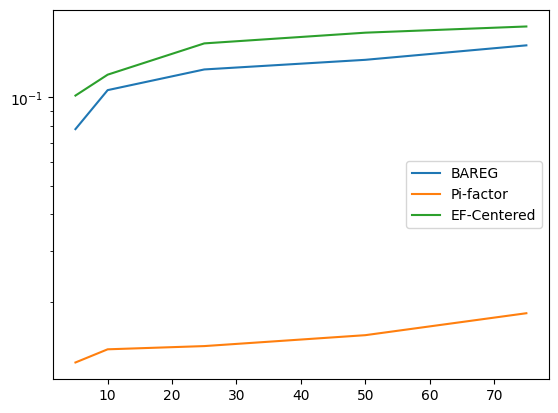

In [24]:
for solver_name in solvers:
    median_stat = df_stat[df_stat['solver'] == solver_name][df_stat['planes_count'] == 5].groupby(
        ['planes_count', 'poses_count', 'points_count']
    ).median()
    indices = list(median_stat.index)
    print(poses_count_list)
    print(median_stat['ape_translation'].values)
    plt.plot(poses_count_list, median_stat['ape_translation'].values)

plt.legend(['BAREG', 'Pi-factor', 'EF-Centered'])
plt.semilogy()